In [16]:
# Useful starting lines
%matplotlib inline
import datetime
from costs import compute_loss
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [20]:
from proj1_helpers import *
DATA_TRAIN_PATH = "train.csv" 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
# standardize the data
tX_std = standardize(tX)

# Implement ML methods

## Least squares GD

In [21]:
def compute_gradient(y, tx, w):
    """
    Compute the gradient.
    
    :param y: labels
    :param tx: features
    :param w: weights
    :return grad: gradient
    """
    grad = (-1/len(y))*tx.T@(y-tx@w)
    return grad
    # ***************************************************


def least_squares_GD(y, tx, initial_w, max_iter, gamma):
    """
    Least square gradient descent
    
    :param y: labels
    :param tx: features
    :param initial_w: initial weights
    :param max_iter: max number of iterations
    :param gamma: learning rate
    :return ws: weights
    :return ls: loss
    """    
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iter):
        gradient = compute_gradient(y,tx,w)
        loss = compute_loss(y,tx,w)
        w = w-gamma*gradient
        ws.append(w)
        losses.append(loss)
        
    return np.array(ws)[-1], np.array(losses)

## Least square SGD

In [22]:

def compute_stoch_gradient(y, tx, w):
    """
    Compute the gradient.
    
    :param y: labels
    :param tx: features
    :param w: weights
    :return grad: gradient
    """    # ***************************************************
    e = y-tx@w
    grad = -1/len(y)*tx.T@e
    return grad
    # ***************************************************


def least_squares_SGD(y, tx, initial_w, batch_size, max_iter, gamma):
    """
    Least square stochastic gradient descent
    
    :param y: labels
    :param tx: features
    :param initial_w: initial weights
    :param batch_size: 1 if sgd
    :param max_iter: max number of iterations
    :param gamma: learning rate
    :return ws: weights
    :return ls: loss
    """   
    ws = []
    losses = []
    w = initial_w
    for n_iter in range(max_iter):
        # compute random batch
        a = batch_iter(y, tx, batch_size, num_batches=1, shuffle=True)
        a = list(a)
        tx2, y2 = a[0][1], a[0][0]
        # compute gradient & loss
        grad = compute_stoch_gradient(y2,tx2,w)
        loss= compute_loss(y2, tx2, w)
        # update gradient
        w = w-gamma*grad
        # store w and loss
        ws.append(w)
        losses.append(loss)


    return np.array(ws)[-1], np.array(losses)

## Least square
computed by solving for w:  X<sup>T</sup>X * w = X<sup>T</sup>y

In [23]:
def least_square(y, tx):
    """
    Solves the closed form least square equation to obtain optimal weights
    
    :param y: labels
    :param tx: features
    :returns w,l: weights and loss of the model
    """
    w = np.linalg.solve(tx.T@tx,tx.T@y)
    l = compute_loss(y, tx, w)
    return w, l


## Ridge regression

In [24]:
def ridge_regression(y, tx, lambda_):
    """
    Solves the closed form of Ridge regression equation to obtain optimal weights
    
    :param y: labels
    :param tx: features
    :param lambda_: regulizer
    :returns w,l: weights and loss of the model
    """
    w = np.linalg.solve(tx.T@tx+lambda_*np.eye(tx.shape[1]),tx.T@y)
    l = compute_loss(y, tx, w)
    return w, l


## Logistic regression

In [25]:
def sigmoid(z):
    """
    sigmoid function
    
    :param z: 
    :return z:
    """
    return 1/(1+np.exp(-z))
def update_weights(y, tx, w, gamma):
    """
    Update weights function for logistic regression
    
    :param tx: features matrix
    :param y: labels vector
    :param w: weights
    :param gamma: learning rate
    
    :return w: new updated weights
    """ 
    #probabilities array that the label is 1
    probabilities = sigmoid(np.dot(tx, w))
    gradient = np.dot(tx.T,  probabilities - y)
    w -= gradient*gamma / len(tx)
    return w

def LR_loss_function(y, tx, w):
    """
    Computes logistic loss
    
    :param tx: features matrix
    :param y: labels vector
    :param w: weights
    
    :return loss: logistic loss
    """ 
    #probabilities array that the label is 1
    probabilities = sigmoid(np.dot(tx, w))
    #the error when label=1
    error1 = -y*np.log(probabilities)
    #the error when label=-1
    error2 = (1-y)*np.log(1-probabilities)
    #return average of sum of costs
    loss = (error1-error2).mean()
    return loss


# logistic regression function
def logistic_regression(y,tx, initial_w,  max_iter, gamma):
    """
    Logistic regression function
    
    :param tx: features matrix
    :param y: labels vector
    :param initial_w: initial weights
    :param max_iter: number of iterations
    :param gamma: learning rate

    :return ls: last loss  computed
    :return ws: last weights computed
    """ 
    losses = []
    ws = []
    for iter_n in range(max_iter):
        w = update_weights(y, tx, initial_w, gamma)
        loss = LR_loss_function(y, tx, w)
        losses.append(loss)
        ws.append(w)
    ls, wes  = np.array(losses), np.array(ws)
    return wes[-1],ls



## Regularized logistic regression

In [26]:
def reg_LR_update_weights(y, tx, w, gamma, lambda_):
    """
    Update weights function for  regularized logistic regression
    
    :param tx: features matrix
    :param y: labels vector
    :param w: weights
    :param gamma: learning rate
    :param lambda_: regulizer
    
    :return w: new updated weights
    """ 
    # probabilities array that the label is 1
    probabilities = sigmoid(np.dot(tx, w))
    gradient = np.dot(tx.T,  probabilities - y) + lambda_ * w
    w -= gradient*gamma / len(tx)
    return w

def reg_LR_loss_function(y, tx, w, lambda_):
    """
    Computes logistic loss
    
    :param tx: features matrix
    :param y: labels vector
    :param w: weights
    :param lambda_: regulizer
    
    :return w: logistic loss
    """ 
    # probabilities array that the label is 1
    probabilities = sigmoid(np.dot(tx, w))
    # the error when label=1
    error1 = -y*np.log(probabilities)
    # the error when label=0
    error2 = (1-y)*np.log(1-probabilities)
    # return average of sum of costs
    return (error1-error2).mean()+lambda_/2*np.dot(w.T,w)/ len(tx)


# regularized logistic regression function
def reg_logistic_regression(y,tx, initial_w,max_iter, gamma,lambda_):
    """
    Regularized logistic regression function
    
    :param tx: features matrix
    :param y: labels vector
    :param initial_w: initial weights
    :param max_iter: number of iterations
    :param gamma: learning rate
    :param lambda_: regulizer

    :return ls: last loss  computed
    :return ws: last weights computed
    """ 
    losses = []
    ws = []
    for iter_n in range(max_iter):
        if(iter_n > 800):
            gamma = gamma-gamma/30
        w = reg_LR_update_weights(y, tx, initial_w, gamma,lambda_)
        loss = reg_LR_loss_function(y, tx, w, lambda_)
        losses.append(loss)
        ws.append(w)
    ls, wes  = np.array(losses), np.array(ws)
    return wes[-1],ls


# Useful functions

In [27]:
def compute_accuracy(y_pred, y):
    """
    compute the accuracy
    
    :param y_pred: predictions
    :param y: real labels
    
    :return acc: accuracy
    """
    # y_pred - y & count 0
    arr = np.array(y_pred) - np.array(y)
    acc = np.count_nonzero(arr==0) / len(y)
    return acc


def build_k_indices(y, k_fold, seed):
    """
    build k indices for k-fold.
    
    :param y: labels
    :param k_fold: number of folds
    :param seed: seed for randomization
    
    :return k_indices: indices 
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)


def build_poly(x, degree):
    """
    polynomial basis functions for input data x, for j=0 up to j=degree.
    
    :param x: matrix 
    :param degree: degree of expansion
    """
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly


def cross_validation(y, x, k_indices, k, degree, regression_method, **kwargs):
    """
    Computes cross validation on a given data set using a given regression method, and computes the
    weights, the train loss, the test loss, and the train and loss accuracy
    if the degree is not none, it will perform feature expansion on the data set
    
    :param y: labels vector
    :param tx: features matrix
    :param k_indices: k_fold already randomly computed indices
    :param degree: degree of polynomial expansion
    :param logistic: boolean; if true, the loss used is the logistic one
    :param **kwargs: differents parameters such as the regulizer lambda or the learning rate gamma
    """
    test_indice = k_indices[k]
    train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    train_indice = train_indice.reshape(-1)
    
    y_test = y[test_indice]
    y_train = y[train_indice]
    x_test = x[test_indice]
    x_train = x[train_indice]
    
    if degree != None:
        x_train = build_poly(x_train, degree)
        x_test = build_poly(x_test, degree)
    

    w_initial = np.zeros(x_train.shape[1])
    kwargs = kwargs
    kwargs['initial_w'] = w_initial

    
    if regression_method is reg_logistic_regression:
        w, loss_train = regression_method(y = y_train, tx = x_train, **kwargs)
        loss_test = reg_LR_loss_function(y_test, x_test, w ,kwargs['lambda_'])
        
    elif regression_method is logistic_regression:
        w, loss_train = regression_method(y = y_train, tx = x_train, **kwargs)
        loss_test = LR_loss_function(y_test, x_test, w)
        
    elif regression_method is least_square:
        w, loss_train = regression_method(y = y_train, tx = x_train)
        loss_test = compute_loss(y_test, x_test, w)
        
    elif regression_method is ridge_regression:
        w, loss_train = regression_method(y_train,x_train, kwargs['lambda_'])
        loss_test = compute_loss(y_test, x_test, w)
    else: 
        w, loss_train = regression_method(y = y_train, tx = x_train, **kwargs)
        loss_test = compute_loss(y_test, x_test, w)

        
    y_train_pred = predict_labels(w, x_train)
    y_test_pred = predict_labels(w, x_test)
    y_test = (y_test*2)-1
    y_train = (y_train*2)-1
    accuracy_train = compute_accuracy(y_train_pred, y_train)
    accuracy_test = compute_accuracy(y_test_pred, y_test)
    return w, loss_train, loss_test, accuracy_train, accuracy_test

def evaluate(tx, wf, degree):
    
    """
    function to evaluate weights over all the train model
    
    :param tx: train features
    :param wf: wights to evaluate
    :param degree: degree of expansion
    :return acc: accuracy of the weights over the train model
    """
    if degree is not None:
        tx =build_poly(tx, degree)
    if isinstance(wf, list):
        wk =np.mean(wf, axis =0)

    else:
        wk = wf
                
    y_pred = predict_labels(wk, tx)
    acc = compute_accuracy(y_std*2-1, y_pred)
    return acc
def remove_outliers_IQR(tx, y, high,low):
    """
    removes outliers using IQR
    
    :param tx: features
    :param y: labels
    :param high: high IQR
    :param low: low IQR
    :returns tX, Y: features and labels without outliers
    """
    Q1 = np.quantile(tX,low,axis = 0)
    Q3 = np.quantile(tX,high, axis = 0)
    IQR = Q3 - Q1
    tX_no_outliers = tX[~((tX < (Q1 - 1.5 * IQR)) |(tX > (Q3 + 1.5 * IQR))).any(axis=1)]
    y_no_outliers = y_std[~((tX < (Q1 - 1.5 * IQR)) |(tX > (Q3 + 1.5 * IQR))).any(axis=1)]
    return tX_no_outliers, y_no_outliers

def replace(tX, value):
    """
    Replaces invalid values with the mean of all the values in the cooresponding feature 

    :param tX: features
    :param value: value to replace
    :return tX: tX with replaced values
    """
    for i in range(tX.shape[1]):
        data = tX[:, i].copy()
        np.delete(data, np.where(data == value))  
        data_median = np.median(data)  
        tX[tX[:, i] == value,i] = data_median  
    return tX

def standardize_test(tx, tx_test):
    """
    Standardize wrt the tx train mean and std
    
    :param tx: train features
    :param tx_test: test features
    :return: std_data: standardized version of tx_test
    """
    value = -999
    tx_test = replace(tx_test, value)
    centered_data = tx_test - np.mean(tx, axis=0)
    std_data = centered_data / np.std(tx, axis=0)
    return std_data

# Train 

## Train function

In [28]:
def train(model,y,tx,k_fold,degree,seed=0, **kwargs):
    """
    regularized logistic regression function 
    
    :param Model: model that we'll use
    :param y: labels vector
    :param tx: features matrix
    :param k_fold: number of folds
    :param degree: degree of polynomial expansion
    :param seed: random seed for cross validation split
    :param **kwargs: multiple possible parameters
    
    :return wf: final weights 
    """    
    weights = []
    losses_train = []
    losses_test = []
    accuracies_train = []
    accuracies_test = []
    
    logistic = False
    if model is logistic_regression or model is reg_logistic_regression:
        logistic = True
    
    k_indices = build_k_indices(y, k_fold, seed)
    for k in tqdm(range(k_fold)):
        w, loss_train, loss_test, accuracy_train, accuracy_test = cross_validation(y, tx, k_indices, k, degree, model, **kwargs)
        weights.append(w)
        losses_train.append(loss_train)
        losses_test.append(loss_test)
        accuracies_train.append(accuracy_train)
        accuracies_test.append(accuracy_test)
    leg = ["train loss "+str(i) for i in range(k_fold)]
    plt.legend(leg)
    plt.plot(losses_train[-1])    
    print("<-"+"-"*75+"->")
    if degree is not None:
        degree = int(degree)
    
    print("{:15.14}|{:15.14}|{:15.14}|{:15.14}|{:15.14}".format("Train losses","Test losses","Train accuracy","Test Accuracy", "Evaluation"))
    for i in range(k_fold):
        if model is least_square or model is ridge_regression:
            print("{:< 15f}|{:< 15f}|{:< 15f}|{:< 15f}|{:< 15f}".format(losses_train[i], losses_test[i] ,accuracies_train[i], accuracies_test[i], evaluate(tX_std, np.array(weights[i]), degree)))
        else:
            print("{:< 15f}|{:< 15f}|{:< 15f}|{:< 15f}|{:< 15f}".format(losses_train[i][-1], losses_test[i] ,accuracies_train[i], accuracies_test[i], evaluate(tX_std, np.array(weights[i]), degree)))
        print("{:15.1}|{:15.14}|{:15.14}|{:15.14}|{:15.14}".format("","","","",""))
    print("<-"+"-"*75+"->")
    print(f"evaluation mean w: {evaluate(tX_std, weights, degree)}")

    return weights, sum(accuracies_train)/len(accuracies_train),sum(accuracies_test)/len(accuracies_test)
    

# Testing without outliers

In [30]:
DATA_TRAIN_PATH = "train.csv" 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
y_std = (y+1)/2


tX_no_outliers, y_no_outliers = remove_outliers_IQR(tX,y_std, 0.85, 0)

tX_no_outliers_std = standardize(tX_no_outliers)


## test least square

In [ ]:
w_ls = train(least_square,y_std,tX_std,5,None,seed=0)


## test least squares Gradient descent 

In [ ]:
w_lsGD = train(least_squares_GD,y_no_outliers,tX_no_outliers_std,5,None,gamma=0.0277184057,seed=0, max_iter = 200)


## test least squares Stochastic Gradient descent 


In [ ]:
w_lsSGD = train(least_squares_SGD,y_no_outliers,tX_no_outliers_std,5,None,gamma=0.0257184057,seed=0,batch_size = 10000, max_iter = 200)


## test Logistic regression 


In [ ]:
w_LR = train(logistic_regression,y_no_outliers,tX_no_outliers_std,5,2,gamma=0.2307184057,seed=0, max_iter = 200)


## test regularized Logistic regression 


In [ ]:
w_regLR = train(reg_logistic_regression,y_no_outliers,tX_no_outliers_std,5,2,gamma=0.227184057,seed=0, max_iter = 300, lambda_ = 0.000770)


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Done about :0.0


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.91s/it]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.337345      | 0.337274      | 0.638500      | 0.635900      | 0.637980      
               |               |               |               |               
 0.337080      | 0.338328      | 0.637770      | 0.637780      | 0.637772      
               |               |               |               |               
 0.337111      | 0.338429      | 0.637640      | 0.637760      | 0.637664      
               |               |               |               |               
 0.336867      | 0.339321      | 0.637555      | 0.639660      | 0.637976      
               |               |               |               |               
 0.338314      | 0.333264      | 0.638070      | 0.638300      | 0.638116      
               |               |               |               |               
<---------------------------------------

ValueError: too many values to unpack (expected 3)

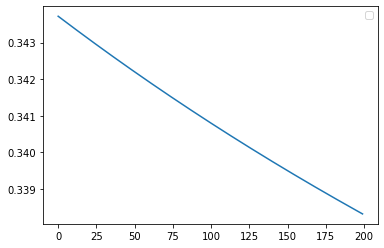

In [47]:

names = [least_squares_GD,least_square, ridge_regression, logistic_regression,reg_logistic_regression]
initial_w  = np.zeros(tX_std.shape[1])
lambdas = np.logspace(-5, 0, 15)
gammas = np.array([0.0001,0.001,0.01,0.1])
degrees = np.array([0,1,2,3,4,5,6,7])
lambda_ = lambdas[0]
gamma = gammas[0]
degree = degrees[0]
#bestParametersLossTrain = [names[0], lambdas[0], gammas[0],degrees[0], 1, initial_w ]
#bestParametersLossTest = [names[0], lambdas[0], gammas[0],degrees[0], 1, initial_w ]
bestParametersAccuracyTrain = [names[0], lambdas[0], gammas[0],degrees[0], 0, initial_w ]
bestParametersAccuracyTest = [names[0], lambdas[0], gammas[0],degrees[0], 0, initial_w ]
for indexML, model_name in enumerate(names):
        print("Done about :" + str(indexML/len(names)))
        if(model_name is least_square or model_name is ridge_regression): #Skip the lambdas
            if(model_name is ridge_regression):
                for indexL,lambda_ in enumerate(lambdas):
                    parameters = [{'initial_w': initial_w, 'max_iter':200,'gamma' : gamma}, {}, {'lambda_' : lambda_}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma,'lambda_' : lambda_}]
                    wTemp, accTr, accTe = train(names[indexML],y_std,tX_std,5,None,0,**parameters[indexML])                
                    if accTr > bestParametersAccuracyTrain[4]:    
                        bestParametersAccuracyTrain = [model_name,lambda_, gamma, None, accTr, wTemp]                    
                    if accTe > bestParametersAccuracyTest[4]:
                        bestParametersAccuracyTest = [model_name,lambda_, gamma, None, accTe, wTemp] 
            else:
                parameters = [{'initial_w': initial_w, 'max_iter':200,'gamma' : gamma}, {}, {'lambda_' : lambda_}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma,'lambda_' : lambda_}]
                wTemp, accTr, accTe = train(names[indexML],y_std,tX_std,5,None,0,**parameters[indexML])                
                if accTr > bestParametersAccuracyTrain[4]:    
                    bestParametersAccuracyTrain = [model_name,lambda_, gamma, None, accTr, wTemp]                    
                if accTe > bestParametersAccuracyTest[4]:
                    bestParametersAccuracyTest = [model_name,lambda_, gamma, None, accTe, wTemp] 
        else:    
            for indexG,gamma in enumerate(gammas):
                if(model_name is reg_logistic_regression):
                    for indexL,lambda_ in enumerate(lambdas):
                        parameters = [{'initial_w': initial_w, 'max_iter':200,'gamma' : gamma}, {}, {'lambda_' : lambda_}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma,'lambda_' : lambda_}]
                        wTemp, accTr, accTe = train(names[indexML],y_std,tX_std,5,None,0,**parameters[indexML])
                        if accTr > bestParametersAccuracyTrain[4]:    
                            bestParametersAccuracyTrain = [model_name,lambda_, gamma, None, accTr, wTemp]                    
                        if accTe > bestParametersAccuracyTest[4]:
                            bestParametersAccuracyTest = [model_name,lambda_, gamma, None, accTe, wTemp]
                else:
                    wTemp, accTr, accTe = train(names[indexML],y_std,tX_std,5,None,0,**parameters[indexML])
                    if accTr > bestParametersAccuracyTrain[4]:    
                        bestParametersAccuracyTrain = [model_name,lambda_, gamma, None, accTr, wTemp]                    
                    if accTe > bestParametersAccuracyTest[4]:
                        bestParametersAccuracyTest = [model_name,lambda_, gamma, None, accTe, wTemp]                        
                #print("Done about : " + str(100*(indexML*len(lambdas)*len(gammas)+ indexL*len(gammas) + indexG)/(len(names)*len(lambdas)*len(gammas))) + "%")
             #   if lossTr < bestParametersLossTrain[4]:
             #       bestParametersLossTrain = [model_name,lambda_, gamma, None, lossTr, wTemp] 
             #   if lossTe < bestParametersLossTest[4]:
             #       bestParametersLossTest = [model_name,lambda_, gamma, None, lossTe, wTemp]                  
                           
                



# Create submission

In [ ]:
# load test data
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

tX_test_std = standardize_test(tX, tX_test)
tX_test_std =build_poly(tX_test_std, 2)
OUTPUT_PATH = 'outLogRegD23v2.csv' 
y_pred = predict_labels(np.mean(w_LR,axis=0), tX_test_std)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)
